In [1]:
import nibabel as nib
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import glob
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from keras.utils import to_categorical

import cv2 as cv
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from keras.callbacks import EarlyStopping
from keras.models import load_model
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [13]:
INPUT_IMAGE_W = 128
INPUT_IMAGE_H = 128
DIR = "BrainHack/"

In [14]:
labels = pd.read_csv(DIR + 'dataset.csv', delimiter = ',', header = 0)
print(labels.shape)
labels.columns

(727, 19)


Index(['Id', 'CT', 'MR', 'GE', 'Siemens', 'Philips', 'Toshiba', 'CTA', 'NCTT',
       'T2W', 'T1W', 'DWI', 'FLAIR', 'GRE', ' 1_5', '3', 'AX', 'SAG', 'COR'],
      dtype='object')

###### Get file names and associate with their labels

In [15]:
files_MR = glob.glob(os.path.join(DIR,'MRI','*','*','*','*','*.nii'))
files_MR_name = []
for files_MR_element in files_MR:
    files_MR_name.append((files_MR_element.rsplit('/', 1)[-1])[:-4])
len(files_MR_name)

label_set = pd.DataFrame(columns = labels.columns)
for name_idx, name in enumerate(files_MR_name):
    temp = np.where(labels["Id"] == name)[0][0]
    label_set.loc[name_idx] = (labels.iloc[temp,:])

###### Get the slices, associate with their labels and put them in an adequate format

In [16]:
raw_dataset = []
raw_dataset_label = pd.DataFrame(columns = labels.columns)
raw_dataset_label_idx = 0

for file_idx, _ in enumerate(files_MR):
    temp_file = nib.load(files_MR[file_idx], keep_file_open = False)
    current_MRI_3D = temp_file.get_fdata()
    temp_file.uncache()
    #del temp_file
    #print("\rOpened the archive number {} of {}". format(file_idx, len(files_MR)))
    
    if current_MRI_3D.ndim == 4:
        for i in range(current_MRI_3D.shape[2]):
            for j in range(current_MRI_3D.shape[3]):
                raw_dataset.append(current_MRI_3D[:,:,i,j])
                raw_dataset_label.loc[raw_dataset_label_idx] = label_set.loc[file_idx]
                raw_dataset_label["Id"][raw_dataset_label_idx] = raw_dataset_label["Id"][raw_dataset_label_idx] + str(i) + "_" + str(j)
                raw_dataset_label_idx = raw_dataset_label_idx + 1
                
    elif current_MRI_3D.ndim == 3:
        for i in range(current_MRI_3D.shape[2]):
                raw_dataset.append(current_MRI_3D[:,:,i])
                raw_dataset_label.loc[raw_dataset_label_idx] = label_set.loc[file_idx]
                raw_dataset_label["Id"][raw_dataset_label_idx] = raw_dataset_label["Id"][raw_dataset_label_idx] + str(i) + "_0"
                raw_dataset_label_idx = raw_dataset_label_idx + 1 


In [18]:
raw_dataset.shape

AttributeError: 'list' object has no attribute 'shape'

###### Reshaping and normalizing images to fixed values, Res: INPUT_IMAGE_W x INPUT_IMAGE_H and values: [0 1]

In [19]:
for img_idx, _ in enumerate(raw_dataset):
    raw_dataset[img_idx] = cv.resize(raw_dataset[img_idx], (INPUT_IMAGE_W, INPUT_IMAGE_H), interpolation = cv.INTER_AREA)      # cubic spline interpolation in a 4x4 environment

#Normalizing slices accordingly to its minimum and maximum value
#Question: would it be better to normalize it accordingly mapping the slices accordingly to the volume's min and max?
for img_idx, _ in enumerate(raw_dataset):
    raw_dataset[img_idx] =  cv.normalize(raw_dataset[img_idx], None, alpha=0, beta=1, norm_type=cv.NORM_MINMAX, dtype=cv.CV_32F)

In [20]:
X = np.asarray(raw_dataset) #-> OS DADOS ESTÃO ORGANIZADOS BONITINHOS AQUI!
X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1) 

Y = raw_dataset_label.iloc[:,1:19]#->O GABARITO ESTÁ BONITINHO AQUI

#WARNING: THERE IS A SPACE BEFORE 1_5!!! CORRECT THIS IN THE FUTURE
Y_training = Y[[' 1_5', '3', 'AX', 'SAG', 'COR']]

In [21]:
print("Verifying if the data is balanced")
print("Slices:")
print("Axial: ", sum(Y_training['AX'] == 1))
print("Sagital: ", sum(Y_training['SAG'] == 1))
print("Coronal: ", sum(Y_training['COR'] == 1))

print("\nStatic Magnetic Field:")
print("1.5T: ", sum(Y_training[' 1_5'] == 1))
print("3T: ", sum(Y_training['3'] == 1))

y_slice = Y_training[['AX', 'SAG', 'COR']]

Verifying if the data is balanced
Slices:
Axial:  19936
Sagital:  1925
Coronal:  1015

Static Magnetic Field:
1.5T:  10390
3T:  12486


###### The slice projections are not balanced at all. The main static MF variations are. A strategy will be adopted before training the slices

## Classifier for the Acquisition Planes

In [22]:
Y_AX = Y_training.loc[Y_training.index[Y_training['AX'] == 1]]
X_slice_AX = np.copy(X[Y_training.index[Y_training['AX'] == 1], :, :, :])

Y_SAG = Y_training.loc[Y_training.index[Y_training['SAG'] == 1]]
X_slice_SAG = np.copy(X[Y_training.index[Y_training['SAG'] == 1], :, :, :])

Y_COR = Y_training.loc[Y_training.index[Y_training['COR'] == 1]]
X_slice_COR = np.copy(X[Y_training.index[Y_training['COR'] == 1], :, :, :])

In [23]:
Max_Sample = max(sum(Y_training['AX'] == 1), sum(Y_training['SAG'] == 1),sum(Y_training['COR'] == 1))

conc_AX = Max_Sample//sum(Y_training['AX'] == 1)
conc_SAG = Max_Sample//sum(Y_training['SAG'] == 1)
conc_COR = Max_Sample//sum(Y_training['COR'] == 1)

print("Replicações para fatias axiais: ", conc_AX-1, "\nReplicações para fatias sagitais: ", conc_SAG-1, "\nReplicações para fatias coronais: ", conc_COR-1)

Replicações para fatias axiais:  0 
Replicações para fatias sagitais:  9 
Replicações para fatias coronais:  18


In [24]:
#PARTE SAGITAL:
X_SAG_replicated = np.copy(X_slice_SAG)
Y_SAG_replicated = Y_SAG

temp_SAG_replicated = np.copy(X_SAG_replicated)
for i, _ in enumerate(X_SAG_replicated):
    temp = cv.flip(temp_SAG_replicated[i,:,:,:], 1)
    temp_SAG_replicated[i, :, :, :] = temp.reshape(temp.shape[0], temp.shape[1], 1)


X_SAG_replicated = np.concatenate([X_SAG_replicated, temp_SAG_replicated], axis = 0)
Y_SAG_replicated = pd.concat([Y_SAG_replicated, Y_SAG_replicated], axis=0)
########2x Bigger!#####

gaussian_noise = np.random.normal(0, 0.05, (X_SAG_replicated.shape[0],X_SAG_replicated.shape[1], X_SAG_replicated.shape[2],X_SAG_replicated.shape[3]))
X_SAG_replicated_noised = np.concatenate([X_SAG_replicated, X_SAG_replicated + gaussian_noise], axis=0)
Y_SAG_replicated_noised = pd.concat([Y_SAG_replicated, Y_SAG_replicated], axis=0)
# 4x Bigger
gaussian_noise = np.random.normal(0, 0.1, (X_SAG_replicated.shape[0],X_SAG_replicated.shape[1], X_SAG_replicated.shape[2],X_SAG_replicated.shape[3]))
X_SAG_replicated = np.concatenate([X_SAG_replicated_noised, X_SAG_replicated + gaussian_noise], axis=0)
Y_SAG_replicated = pd.concat([Y_SAG_replicated_noised, Y_SAG_replicated], axis=0)
# 6x Bigger (Duplicated with Flipped image + Version with Noise G(0, 1), and version G(0, 0.5))

#PARTE CORITAL:
X_COR_replicated = np.copy(X_slice_COR)
Y_COR_replicated = Y_COR

temp_COR_replicated = np.copy(X_COR_replicated)
for i, _ in enumerate(X_COR_replicated):
    temp = cv.flip(temp_COR_replicated[i,:,:,:], 1)
    temp_COR_replicated[i, :, :, :] = temp.reshape(temp.shape[0], temp.shape[1], 1)


X_COR_replicated = np.concatenate([X_COR_replicated, temp_COR_replicated], axis = 0)
Y_COR_replicated = pd.concat([Y_COR_replicated, Y_COR_replicated], axis=0)
########2x Bigger!#####

gaussian_noise = np.random.normal(0, 0.05, (X_COR_replicated.shape[0],X_COR_replicated.shape[1], X_COR_replicated.shape[2],X_COR_replicated.shape[3]))
X_COR_replicated_noised = np.concatenate([X_COR_replicated, X_COR_replicated + gaussian_noise], axis=0)
Y_COR_replicated_noised = pd.concat([Y_COR_replicated, Y_COR_replicated], axis=0)
# 4x Bigger
gaussian_noise = np.random.normal(0, 0.1, (X_COR_replicated.shape[0],X_COR_replicated.shape[1], X_COR_replicated.shape[2],X_COR_replicated.shape[3]))
X_COR_replicated = np.concatenate([X_COR_replicated_noised, X_COR_replicated + gaussian_noise], axis=0)
Y_COR_replicated = pd.concat([Y_COR_replicated_noised, Y_COR_replicated], axis=0)
# 6x Bigger (Duplicated with Flipped image + Version with Noise G(0, 1), and version G(0, 0.5))

In [25]:
X_AX_replicated = X_slice_AX
Y_AX_replicated = Y_AX
#for i in range(conc_AX - 1):
#    X_AX_replicated = np.concatenate([X_AX_replicated, X_slice_AX], axis=0)
#    Y_AX_replicated = pd.concat([Y_AX_replicated, Y_AX], axis=0)
#    
X_slice = np.concatenate([X_AX_replicated, X_SAG_replicated, X_COR_replicated])
for img_idx, _ in enumerate(X_slice):
    temp = X_slice[img_idx]
    temp =  cv.normalize(temp[:, :, 0], None, alpha=0, beta=1, norm_type=cv.NORM_MINMAX, dtype=cv.CV_32F)
    temp = temp.reshape(temp.shape[0], temp.shape[1], 1)
    X_slice[img_idx] = temp
    
Y_slice = pd.concat([Y_AX_replicated, Y_SAG_replicated, Y_COR_replicated])



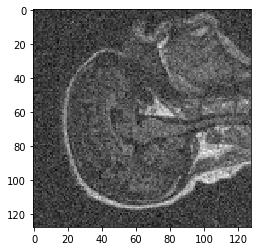

In [26]:
id = 10000
plt.imshow(X_SAG_replicated[id, :, :, 0], cmap = 'gray')
plt.show()
#plt.imshow(temp_SAG_replicated[id, :, :, 0], cmap = 'gray')
#plt.show()

In [ ]:
temp_SAG_replicated.shape

### Making the data more balanced by decreasing the amount of each class to the one that has the least samples

In [27]:
Y_slice = Y_slice[['AX', 'SAG', 'COR']]

In [28]:
X_slice = np.asarray(X_slice)
X_slice = X_slice.reshape(X_slice.shape[0], X_slice.shape[1], X_slice.shape[2], 1)
X_bal_training, X_bal_test, y_bal_training, y_bal_test = train_test_split(X_slice, Y_slice, test_size=0.1, random_state=42)
X_bal_train, X_bal_val, y_bal_train, y_bal_val = train_test_split(X_bal_training, y_bal_training, test_size=0.222, random_state=42)

In [37]:
model_Slice = Sequential()
model_Slice.add(Conv2D(8, kernel_size=3, activation="relu", input_shape=(INPUT_IMAGE_W,INPUT_IMAGE_H,1)))
model_Slice.add(Conv2D(4, kernel_size=3, activation="relu"))
model_Slice.add(Flatten())
model_Slice.add(Dense(3, activation="softmax"))
model_Slice.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')


In [38]:
model_Slice.fit(X_bal_train, y_bal_train, validation_data=(X_bal_val, y_bal_val), epochs=150, callbacks=[es, mcp_save])

Train on 26310 samples, validate on 7508 samples
Epoch 1/150
26310/26310 [==============================] - 265s 10ms/step - loss: 0.1896 - accuracy: 0.9375 - val_loss: 0.0851 - val_accuracy: 0.9744
Epoch 2/150
26310/26310 [==============================] - 242s 9ms/step - loss: 0.0536 - accuracy: 0.9843 - val_loss: 0.0646 - val_accuracy: 0.9798
Epoch 3/150
26310/26310 [==============================] - 179s 7ms/step - loss: 0.0246 - accuracy: 0.9934 - val_loss: 0.0819 - val_accuracy: 0.9736
Epoch 4/150
26310/26310 [==============================] - 171s 7ms/step - loss: 0.0159 - accuracy: 0.9961 - val_loss: 0.0712 - val_accuracy: 0.9751
Epoch 5/150
26310/26310 [==============================] - 173s 7ms/step - loss: 0.0144 - accuracy: 0.9962 - val_loss: 0.0647 - val_accuracy: 0.9815
Epoch 6/150
26310/26310 [==============================] - 256s 10ms/step - loss: 0.0077 - accuracy: 0.9981 - val_loss: 0.0562 - val_accuracy: 0.9831
Epoch 7/150
26310/26310 [==============================

In [39]:
scores = model_Slice.evaluate(X_bal_test, y_bal_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))


Accuracy: 98.43%


In [40]:
model_Slice.save("model_Slice.h5")

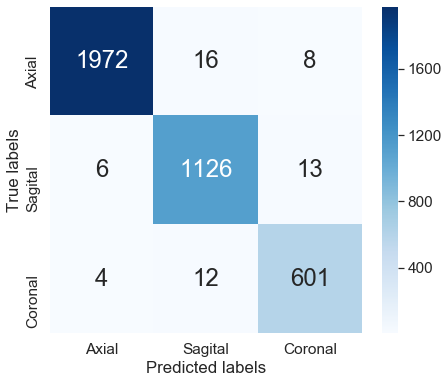

In [41]:
# Confusion matrix
model = load_model("model_Slice.h5")
y_pred = model.predict(X_bal_test)
y_bal_test = np.array(y_bal_test)
classes = ['Axial', 'Sagital', 'Coronal']
cm = confusion_matrix(np.argmax(y_bal_test, axis=1), np.argmax(y_pred, axis=1))
cmap = plt.cm.Blues

# labels, title and ticks


df_cm = pd.DataFrame(cm, range(3),range(3))
plt.figure(figsize = (7,6))
sns.set(font_scale=1.4)#for label size
ax= plt.subplot()
sns.heatmap(df_cm, annot=True,annot_kws={"size": 24}, cmap=cmap, ax = ax, fmt = 'd')
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
#ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(classes); 
ax.yaxis.set_ticklabels(classes);

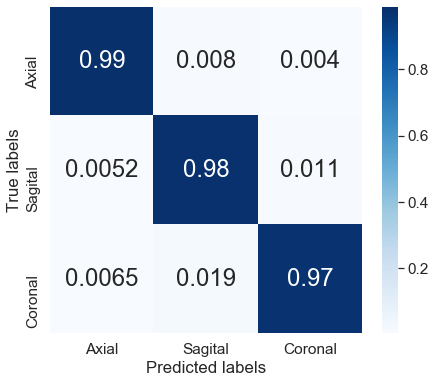

In [42]:
# Confusion matrix
model = load_model("model_Slice.h5")
y_pred = model.predict(X_bal_test)
y_bal_test = np.array(y_bal_test)
classes = ['Axial', 'Sagital', 'Coronal']
cm = confusion_matrix(np.argmax(y_bal_test, axis=1), np.argmax(y_pred, axis=1))
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cmap = plt.cm.Blues

# labels, title and ticks


df_cm = pd.DataFrame(cm, range(3),range(3))
plt.figure(figsize = (7,6))
sns.set(font_scale=1.4)#for label size
ax= plt.subplot()
sns.heatmap(df_cm, annot=True,annot_kws={"size": 24}, cmap=cmap, ax = ax)
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
#ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(classes); 
ax.yaxis.set_ticklabels(classes);

In [ ]:
np.argmax(y_bal_test, axis=1)[1:50]

In [ ]:
np.argmax(y_bal_test, axis=1)[1:50]

In [ ]:
# Confusion matrix
model = load_model("model_Slice.h5")
y_pred = model.predict(X_bal_test)
y_bal_test = np.array(y_bal_test)
classes = ['Axial', 'Sagital', 'Coronal']
cm = confusion_matrix(np.argmax(y_bal_test, axis=1), np.argmax(y_pred, axis=1))
cmap = plt.cm.Blues

# labels, title and ticks


df_cm = pd.DataFrame(cm, range(3),range(3))
plt.figure(figsize = (7,6))
sns.set(font_scale=1.4)#for label size
ax= plt.subplot()
sns.heatmap(df_cm, annot=True,annot_kws={"size": 24}, cmap=cmap, ax = ax, fmt = 'd')
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
#ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(classes); 
ax.yaxis.set_ticklabels(classes);